## Value-at-Risk: Forecast Evaluation

**Functions**

`sm.OLS`, `stats.bernoulli`

### Exercise 83
    
Compare this VaR to the HS VaR in the previous example.

Let's begin by importing and transforming the data.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Load Data
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")        
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

with pd.HDFStore("./data/hs-var.h5", mode="r") as hdf:
    sp500_hs = hdf.get("sp500_var")
    eurusd_hs = hdf.get("eurusd_var")
with pd.HDFStore("./data/fhs-var.h5", mode="r") as hdf:
    sp500_fhs = hdf.get("sp500_var")
    eurusd_fhs = hdf.get("eurusd_var")

In [3]:
# HS data
sp500hs = sp500_hs['1-day 5% VaR']
sp500hs.name = 'SP500 HS 5% VaR'
eurusdhs = eurusd_hs['1-day 5% VaR']
eurusdhs.name = 'EURUSD HS 5% VaR'
# FHS data
sp500_fhs.name = 'SP500 FHS 5% VaR'
eurusd_fhs.name = 'EURUSD FHS 5% VaR'

In [4]:
# Concatenating
sp500_var = pd.concat([sp500_fhs, sp500hs],axis=1)
eurusd_var = pd.concat([eurusd_fhs, eurusdhs], axis=1)

Now that we have all the data we need in two dataframes, let's plot to compare the two forecasts:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,12))
plt.rc("font", size=16)

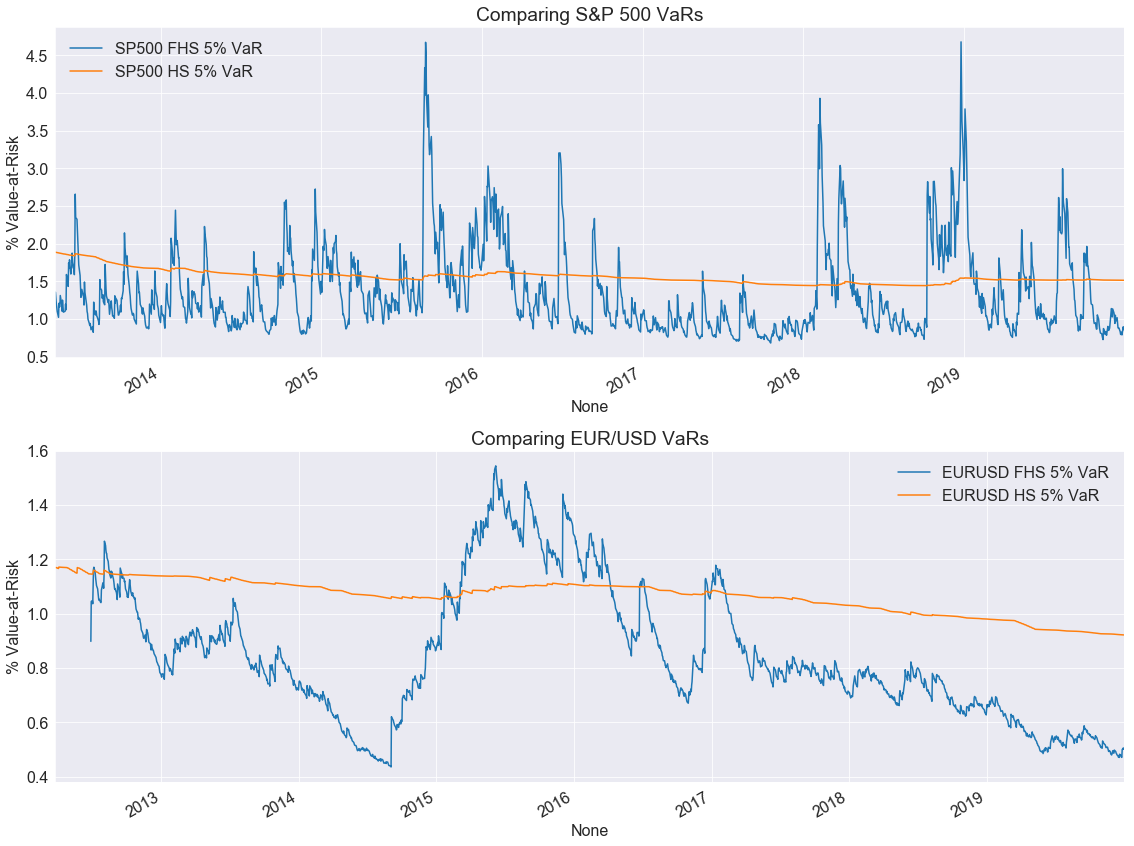

In [7]:
# Doing the plots
fig, axes = plt.subplots(2,1)
# For SP500
ax = sp500_var.plot(ax=axes[0],legend=False)
ax.set_title(f"Comparing S&P 500 VaRs")
ax.set_xlabel(None)
ax.set_ylabel("% Value-at-Risk")
ax.legend(frameon=False)
ax.set_xlim(sp500_var.index.min(), sp500_var.index.max())
# For EURUSD
ax = eurusd_var.plot(ax=axes[1], legend=False)
ax.set_title(f"Comparing EUR/USD VaRs")
ax.set_xlabel(None)
ax.set_ylabel("% Value-at-Risk")
ax.set_xlim(eurusd_var.index.min(), eurusd_var.index.max())
ax.legend(frameon=False)
fig.tight_layout(pad=1.0)

The HS VaRs are very smooth while the FHS VaRs are more dynamic.  The FHS VaRs are mostly driven by changes in volatility. The dynamics in the EUR/USD data are substantially different with long-swings evident in volatility.

### Exercise 84
Evaluate the FHS and HS VaR forecasts constructed in the previous exercises using:

* HIT tests
* The Bernoulli test for unconditionally correct VaR
* Christoffersen’s test for conditionally correct VaR


We will peform the forecast evaluation for the SP500 series, but all holds for the EURUSD series. We can begin our evaluation by taking a look at the HITs:

In [8]:
# Construct HITS
combined = pd.concat([sp500_returns, sp500_var], axis=1).dropna()
combined.columns = ["ret","fhs","hs"]
hit_fhs = combined.ret < -combined.fhs
hit_hs = combined.ret < -combined.hs
hits = pd.DataFrame({"hit_fhs":hit_fhs,"hit_hs":hit_hs}).astype("float")

In [9]:
# Checking HITs    
print(hits.mean())
print(hits.corr())

hit_fhs    0.011926
hit_hs     0.038163
dtype: float64
          hit_fhs    hit_hs
hit_fhs  1.000000  0.494202
hit_hs   0.494202  1.000000


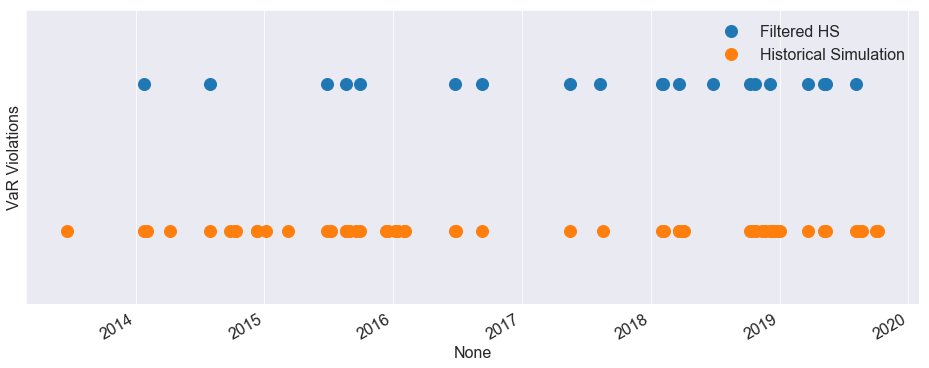

In [10]:
# Plotting when HITs happened
temp = hits.replace(0.0,np.nan)
temp.iloc[:,0] += 0.05
temp.iloc[:,1] -= 0.05
temp.columns = ["Filtered HS", "Historical Simulation"]
plt.rc("figure", figsize=(16,6))
ax = temp.plot(marker="o",linestyle="none",legend=False, markersize=12)
ax.set_ylim(0.9,1.10)
ax.set_yticks([])
ax.set_ylabel("VaR Violations")
ax.set_xlabel(None)
ax.legend(frameon=False)

We see that both produce fewer HITs than they should, and that the FHS is particularly bad. The are mildly correlated with about half of the HITs being observed in the same period. The HS violation appear to be clustered in 2016 and 2019. 

## Unconditional Evaluation of VaR using the Bernoulli Test

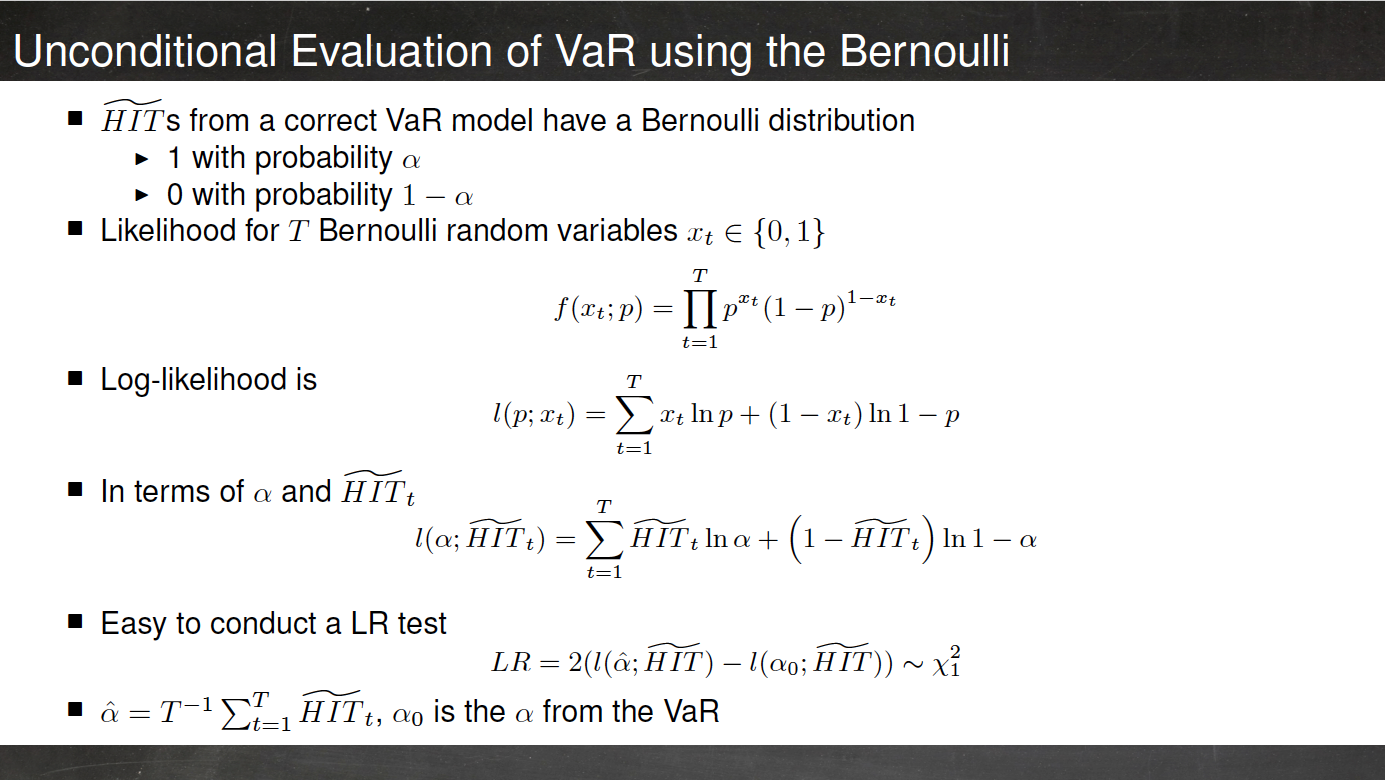

Ok! Let's build this test for both HIT series:

In [11]:
# Looping for each model (FHS and HS)
for col in hits:
    # Gettin HIT series
    hit = hits[col]
    # Caculating mean
    phat = hit.mean()
    # Calcualting bernoulli likelihood for HITs
    llf = stats.bernoulli(phat).logpmf(hit).sum()
    # Calcualting bernoulli likelihood under null
    llf0 = stats.bernoulli(0.05).logpmf(hit).sum()
    # Calculating likelihood ratio
    lr = 2 * (llf - llf0)
    # Calculating test statistic
    pval = 1 - stats.chi2(1).cdf(lr)
    print(f"Method: {col} LR: {lr} P-value: {pval}")

Method: hit_fhs LR: 72.89356408124885 P-value: 0.0
Method: hit_hs LR: 5.36756225606814 P-value: 0.02051462885787303


The results from the Bernoulli reinforce what we saw by looking at the means. Both models are rejected but FHS seems to perform worse than HS.

## Evaluation of Conditional VaR using Christoffersen’s test

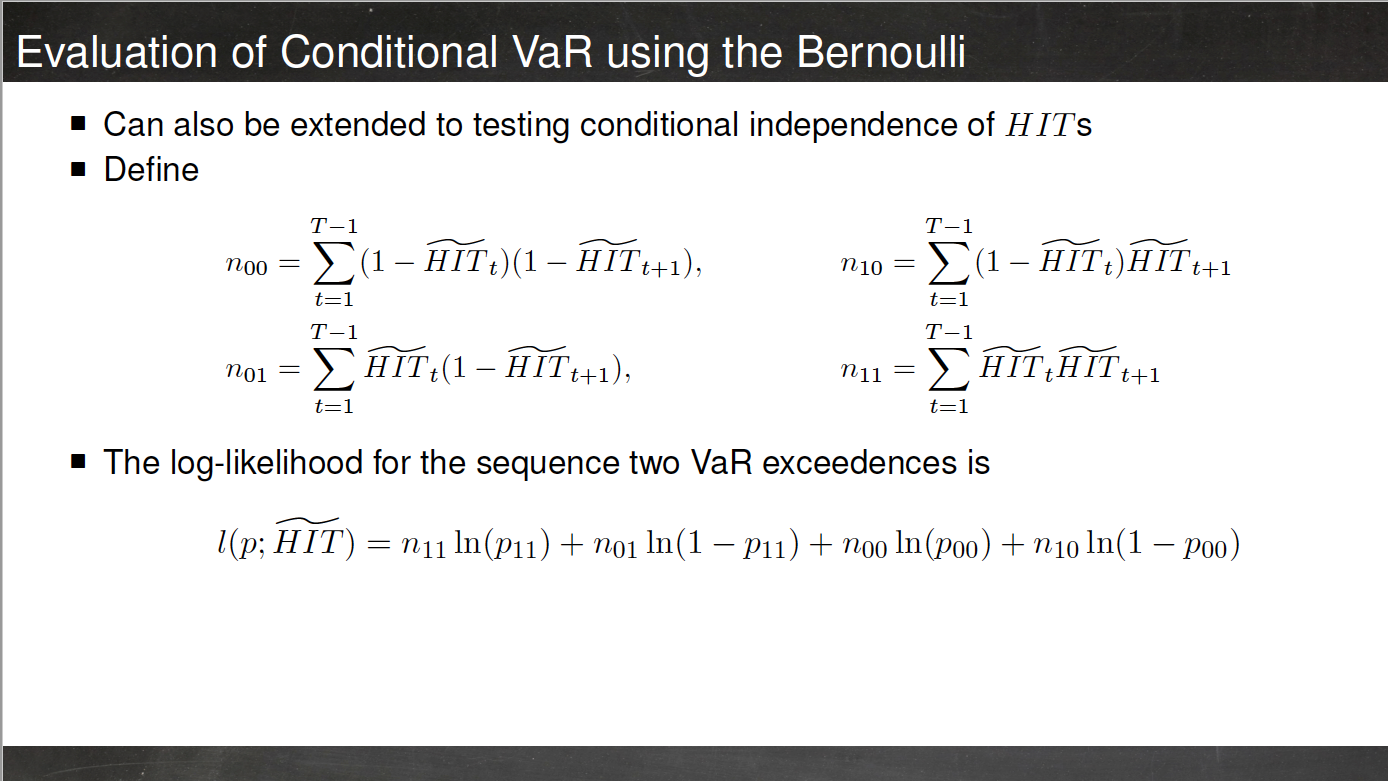

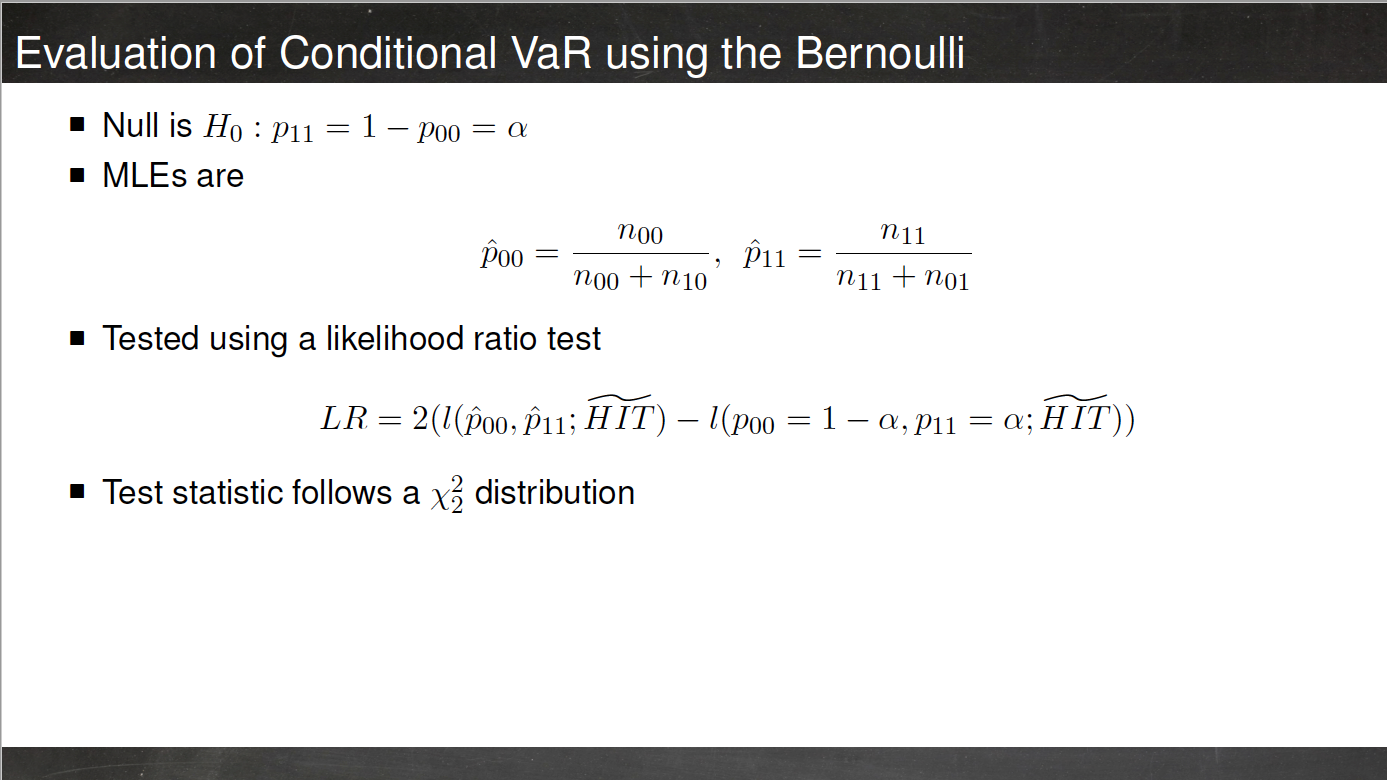

In [12]:
# Looping for each model (FHS and HS)
for col in hits:
    # Gettin HIT series
    hit = hits[col]
    # Getting lag hits
    hit_t = hit.shift(1)
    hit_tp1 = hit
    # Calculating n sums
    n00 = ((1-hit_t) * (1-hit_tp1)).sum()
    n10 = (hit_t * (1-hit_tp1)).sum() 
    n01 = ((1-hit_t) * hit_tp1).sum()
    n11 = (hit_t * hit_tp1).sum()
    # Calculating probabilities
    p00_hat = n00 / (n00 + n01)
    p11_hat = n11 / (n11 + n10)
    p00 = p00_hat
    p11 = p11_hat
    # Calculating data likelihood
    llf = n00*np.log(p00) + n10 * np.log(1-p00) + n11 * np.log(p11) + n10 * np.log(1-p11)
    # Calculating likelihood under the null
    p11 = .05
    p00 = 1 - p11
    llf0 = n00*np.log(p00) + n10 * np.log(1-p00) + n11 * np.log(p11) + n10 * np.log(1-p11)
    # Calculating likelihood ratio
    lr = 2 * (llf - llf0)
    # Calculating test statistic
    pval = 1 - stats.chi2(2).cdf(lr)
    print(f"Christoffersen's test, Method: {col} LR: {lr} P-value: {pval}")

Christoffersen's test, Method: hit_fhs LR: 74.21749440279362 P-value: 1.1102230246251565e-16
Christoffersen's test, Method: hit_hs LR: 23.86935488046379 P-value: 6.558966978320591e-06


The result from the Christoffersen's test further reinforces the result from the previous tests. We can reject the null for both models, indicading neither performs well when we evaluate VaR performance condionally. The FHS seems to perform even worse than the HS.